In [2]:
import os
import cv2
import csv
import pandas as pd
import numpy as np
import mediapipe as mp
import plotly.express as px 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.animation as animation
from IPython.display import HTML
from mediapipe.framework.formats import landmark_pb2

2023-07-08 10:23:28.721154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
asl = 'sign_data/asl-signs'
train_df = pd.read_csv(f"{asl}/train.csv")

In [25]:
train_df

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


In [4]:
words = train_df.sign.value_counts().to_frame().reset_index()
words

,sign,count
0,listen,415
1,look,414
2,shhh,411
3,donkey,410
4,mouse,408
...,...,...
245,dance,312
246,person,312
247,beside,310
248,vacuum,307


In [5]:
len(words)

250

<BarContainer object of 10 artists>

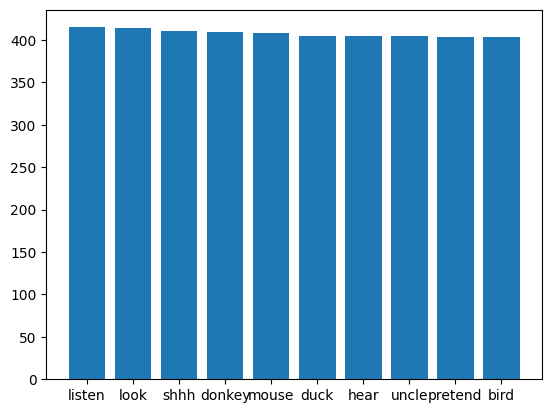

In [6]:
plt.bar(words['sign'][:10], words['count'][:10])



In [26]:
entry = train_df.query('sign == "hello"')["path"].values[2]
entry_landmark = pd.read_parquet(f"{asl}/{entry}")
entry_landmark.head()

,frame,row_id,type,landmark_index,x,y,z
0,12,12-face-0,face,0,0.592258,0.443662,-0.036086
1,12,12-face-1,face,1,0.588944,0.413303,-0.074681
2,12,12-face-2,face,2,0.587292,0.422296,-0.037463
3,12,12-face-3,face,3,0.571926,0.375798,-0.060201
4,12,12-face-4,face,4,0.588335,0.402126,-0.080420


In [28]:
entry_landmark.frame.unique()

array([12, 13, 14, 15, 16, 17, 18, 19], dtype=int16)

In [37]:
entry_landmark.query('frame == 13 and type == "left_hand"')

,frame,row_id,type,landmark_index,x,y,z
1011,13,13-left_hand-0,left_hand,0,NaN,NaN,NaN
1012,13,13-left_hand-1,left_hand,1,NaN,NaN,NaN
1013,13,13-left_hand-2,left_hand,2,NaN,NaN,NaN
1014,13,13-left_hand-3,left_hand,3,NaN,NaN,NaN
1015,13,13-left_hand-4,left_hand,4,NaN,NaN,NaN
1016,13,13-left_hand-5,left_hand,5,NaN,NaN,NaN
1017,13,13-left_hand-6,left_hand,6,NaN,NaN,NaN
1018,13,13-left_hand-7,left_hand,7,NaN,NaN,NaN
1019,13,13-left_hand-8,left_hand,8,NaN,NaN,NaN
1020,13,13-left_hand-9,left_hand,9,NaN,NaN,NaN


In [6]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [7]:
frame = load_relevant_data_subset(f"{asl}/{entry}")
frame[0]

array([[ 0.5922584 ,  0.4436624 , -0.03608583],
       [ 0.58894414,  0.41330278, -0.07468054],
       [ 0.58729196,  0.42229626, -0.03746279],
       ...,
       [ 0.10385577,  0.27334157, -0.04179677],
       [ 0.11813042,  0.24242613, -0.04762791],
       [ 0.13784009,  0.2143364 , -0.04887249]], dtype=float32)

In [8]:
frame.shape

(8, 543, 3)

In [9]:
def landmark_order(sequence):
    n_frames = int(len(sequence) / ROWS_PER_FRAME)
    data = sequence.values.reshape(n_frames, ROWS_PER_FRAME, len(sequence.columns))
    return np.unique(data[:,:,2:4].astype(str), axis=0)

reference_order = landmark_order(entry_landmark)

def aggregate_info(row):
    path, sign = row['path'], row['sign']
    sequence = pd.read_parquet(f"{asl}/{path}")
    start_frame = sequence.frame.min()
    end_frame = sequence.frame.max()
    n_frames = end_frame - start_frame + 1
    order_consistent = (landmark_order(sequence) == reference_order).all()
    agg = pd.concat({
        'any': sequence.groupby(['frame','type'])[['x','y','z']].agg(lambda c: c.isnull().any()).any(axis=1),
        # 'all': sequence.groupby(['frame','type'])[['x','y','z']].agg(lambda c: c.isnull().all()).all(axis=1),
    }, axis=1).reset_index().groupby('type').sum()
    del sequence
    agg = pd.melt(agg.reset_index(), id_vars=['type'], value_vars=['any'])
    agg.index = agg.type + '_' + agg.variable
    info = agg['value'].copy().sort_index()
    del agg
    info.name = 'info'
    info['sign'] = sign  # Add the sign
    info['start_frame'] = start_frame
    info['end_frame'] = end_frame
    info['n_frames'] = n_frames
    info['order_consistent'] = order_consistent
    return info

In [70]:
# Apply function to each row
agg = train_df[['path', 'sign']][:50].apply(aggregate_info, axis=1)

# Get the column names as a list
cols = list(agg.columns)
# Move 'sign' to the front of the list
cols.insert(0, cols.pop(cols.index('sign')))
agg = agg.reindex(columns=cols)
agg.head(20)

,sign,face_any,left_hand_any,pose_any,right_hand_any,start_frame,end_frame,n_frames,order_consistent
0,blow,0,23,0,12,20,42,23,True
1,wait,0,11,0,9,29,39,11,True
2,cloud,0,77,0,105,103,207,105,True
3,bird,0,12,0,0,17,28,12,True
4,owie,0,18,0,0,22,39,18,True
5,duck,0,30,0,0,20,49,30,True
6,minemy,0,23,0,0,27,49,23,True
7,lips,0,21,0,57,4,60,57,True
8,flower,1,49,0,24,23,71,49,True
9,time,0,19,0,16,0,18,19,True


In [110]:
def landmarklists(sig_n, framenum):
    random_example_file_path = train_df.query("sign==@sig_n")["path"].iloc[0]
    random_example_file = pd.read_parquet(f'{asl}/{random_example_file_path}')
    f1 = random_example_file.dropna().query("frame==@framenum")

    # Creating the NormalizedLandmarkList for each type
    landmark_list_face = landmark_pb2.NormalizedLandmarkList()
    landmark_list_pose = landmark_pb2.NormalizedLandmarkList()
    landmark_list_left_hand = landmark_pb2.NormalizedLandmarkList()
    landmark_list_right_hand = landmark_pb2.NormalizedLandmarkList()

    for i, row in f1.iterrows():
        if row["type"] == "face":
            landmark = landmark_list_face.landmark.add()
            landmark.x = row["x"]
            landmark.y = row["y"]
            landmark.z = row["z"]
        elif row["type"] == "pose":
            landmark = landmark_list_pose.landmark.add()
            landmark.x = row["x"]
            landmark.y = row["y"]
            landmark.z = row["z"]
        elif row["type"] == "left_hand":
            landmark = landmark_list_left_hand.landmark.add()
            landmark.x = row["x"]
            landmark.y = row["y"]
            landmark.z = row["z"]
        elif row["type"] == "right_hand":
            landmark = landmark_list_right_hand.landmark.add()
            landmark.x = row["x"]
            landmark.y = row["y"]
            landmark.z = row["z"]

    results = {}
    results["pose_landmarks"] = landmark_list_pose
    results["left_hand_landmarks"] = landmark_list_left_hand
    results["right_hand_landmarks"] = landmark_list_right_hand
    results["face_landmarks"] = landmark_list_face
    return results

results = landmarklists("listen", 40)

x: 0.5379732
y: 0.3673297
z: -1.4710416

x: 0.574971
y: 0.320292
z: -1.3746433

x: 0.603144
y: 0.31942755
z: -1.3749156

x: 0.6297967
y: 0.3191769
z: -1.3757629

x: 0.48878583
y: 0.32725182
z: -1.3556522

x: 0.46310225
y: 0.33139226
z: -1.3551153

x: 0.44018224
y: 0.3355412
z: -1.355556

x: 0.67387587
y: 0.34034637
z: -0.7040495

x: 0.41851968
y: 0.36321285
z: -0.5719953

x: 0.595347
y: 0.42296034
z: -1.2267416

x: 0.49330446
y: 0.4253815
z: -1.1931515

x: 0.8981238
y: 0.6215836
z: -0.43508452

x: 0.3271068
y: 0.61313486
z: -0.40346682

x: 1.0649151
y: 0.9615241
z: -0.4700961

x: 0.11807884
y: 0.8259506
z: -1.4304509

x: 1.0057809
y: 1.2591944
z: -0.7900605

x: 0.18362904
y: 0.5992336
z: -2.9842525

x: 1.0144924
y: 1.3713932
z: -0.90404934

x: 0.1619393
y: 0.5357703
z: -3.2881465

x: 0.93982893
y: 1.363159
z: -0.9700491

x: 0.20022352
y: 0.5215023
z: -3.2424808

x: 0.92864835
y: 1.3204188
z: -0.82956934

x: 0.22426453
y: 0.5532885
z: -3.0153234

x: 0.77899927
y: 1.2489148
z: -0.1655419

In [11]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
mp_hands = mp.solutions.hands

In [112]:
def plot_landmarks(results):
    # creating black background
    bg_img = np.zeros([1300, 1146, 3])

    # drawing landmarks if landmark_list is not empty
    if len(results["face_landmarks"].landmark) != 0:
        mp_drawing.draw_landmarks(
            bg_img,
            results["face_landmarks"],
            mp_holistic.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style(),
            #             mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2),
            #             mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
        )
    if len(results["pose_landmarks"].landmark) != 0:
        mp_drawing.draw_landmarks(
            bg_img,
            results["pose_landmarks"],
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
            #             mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=5, circle_radius=5),
            #             mp_drawing.DrawingSpec(color=(0, 50, 100), thickness=5, circle_radius=2),
        )
        print(results)
    if len(results["right_hand_landmarks"].landmark) != 0:
        mp_drawing.draw_landmarks(
            bg_img,
            results["right_hand_landmarks"],
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style(),
        )
    if len(results["left_hand_landmarks"].landmark) != 0:
        mp_drawing.draw_landmarks(
            bg_img,
            results["left_hand_landmarks"],
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style(),
        )
    # plotting the landmarks
    plt.imshow(bg_img)

In [10]:
entry_landmark

,frame,row_id,type,landmark_index,x,y,z
0,12,12-face-0,face,0,0.592258,0.443662,-0.036086
1,12,12-face-1,face,1,0.588944,0.413303,-0.074681
2,12,12-face-2,face,2,0.587292,0.422296,-0.037463
3,12,12-face-3,face,3,0.571926,0.375798,-0.060201
4,12,12-face-4,face,4,0.588335,0.402126,-0.080420
...,...,...,...,...,...,...,...
4339,19,19-right_hand-16,right_hand,16,0.229135,0.158524,-0.118407
4340,19,19-right_hand-17,right_hand,17,0.137646,0.354542,-0.070975
4341,19,19-right_hand-18,right_hand,18,0.142946,0.291110,-0.099266
4342,19,19-right_hand-19,right_hand,19,0.157974,0.248765,-0.112596


In [11]:

data_2 = entry_landmark

In [12]:

valid_frames = []

for i in data_2['frame'].unique():
    left_hand_coords = data_2[(data_2['frame'] == i) & (data_2['type'] == 'left_hand')][['x', 'y']].values
    right_hand_coords = data_2[(data_2['frame'] == i) & (data_2['type'] == 'right_hand')][['x', 'y']].values
    # Check if both hands have valid coordinates
    if (not np.isnan(left_hand_coords).any() and left_hand_coords.shape[0] > 0) or (not np.isnan(right_hand_coords).any() and right_hand_coords.shape[0] > 0):
        valid_frames.append(i)
print(valid_frames)

# Remove duplicates from valid_frames
valid_frames = list(set(valid_frames))

# Now, let's remove frames with no hand landmarks from data_2
data_2 = data_2[data_2['frame'].isin(valid_frames)]
print(len(valid_frames))


[12, 13, 14, 15, 16, 17, 18, 19]
8


In [56]:
from IPython.display import display


# Define a drawing function that will be called for each frame
# fig = plt.figure()  # Create a new figure
# Define a drawing function that will be called for each frame
fig, ax = plt.subplots()  # Create a new figure and axes
plt.close()  # Close the figure to prevent it from being displayed in the output

def draw(i):
    ax.clear()
    plt.clf()  # Close the current plot
    image = np.zeros((480, 640, 3), dtype=np.uint8)  # Create a blank image

    for hand_type in ['left_hand', 'right_hand']:
        # Create a dataframe for the current frame and hand type
        df = data_2[(data_2['frame'] == i) & (data_2['type'] == hand_type)]

        if df.empty:
            continue
        
        # Create a NormalizedLandmarkList for the hand
        hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        for _, row in df.iterrows():
            landmark = hand_landmarks.landmark.add()
            landmark.x, landmark.y = row[['x', 'y']]

        # Draw the hand landmarks
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=hand_landmarks,
            connections=mp_hands.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=2),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=2)
        )

    # Create a dataframe for the current frame and face type
    df = data_2[(data_2['frame'] == i) & (data_2['type'] == 'face')]

    if not df.empty:
        # Create a NormalizedLandmarkList for the face
        face_landmarks = landmark_pb2.NormalizedLandmarkList()
        for _, row in df.iterrows():
            landmark = face_landmarks.landmark.add()
            landmark.x, landmark.y= row[['x', 'y']]

        # Draw the face landmarks
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_holistic.FACEMESH_TESSELATION,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=1, circle_radius=1),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
        )

    # Create a dataframe for the current frame and pose type
    df = data_2[(data_2['frame'] == i) & (data_2['type'] == 'pose')]

    if not df.empty:
        # Create a NormalizedLandmarkList for the pose
        pose_landmarks = landmark_pb2.NormalizedLandmarkList()
        for _, row in df.iterrows():
            landmark = pose_landmarks.landmark.add()
            landmark.x, landmark.y = row[['x', 'y']]

        # Draw the pose landmarks
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=pose_landmarks,
            connections=mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1)
        )

    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax.imshow(image)
    
# Create an animation by repeatedly calling draw() function
ani = animation.FuncAnimation(fig, draw, frames=valid_frames, interval=100)
# Close the figure to prevent it from being displayed
plt.close(fig)
# Convert the animation to HTML and display it
HTML(ani.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [106]:
# Define a figure
fig = plt.figure(figsize=(10,10))

# Define a drawing function that will be called for each frame
def draw(i):
    plt.clf()  # Clear the current plot

    results = landmarklists('blow', i)

    # creating black background
    bg_img = np.zeros([1300, 1146, 3])

    # drawing landmarks if landmark_list is not empty
    if len(results["face_landmarks"].landmark) != 0:
        mp_drawing.draw_landmarks(
            bg_img,
            results["face_landmarks"],
            mp_holistic.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style(),
        )
    if len(results["pose_landmarks"].landmark) != 0:
        mp_drawing.draw_landmarks(
            bg_img,
            results["pose_landmarks"],
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
        )
    if len(results["right_hand_landmarks"].landmark) != 0:
        mp_drawing.draw_landmarks(
            bg_img,
            results["right_hand_landmarks"],
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style(),
        )
    if len(results["left_hand_landmarks"].landmark) != 0:
        mp_drawing.draw_landmarks(
            bg_img,
            results["left_hand_landmarks"],
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style(),
        )

    # Convert the image from BGR to RGB
    image = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)

    plt.imshow(image)

# Create an animation by repeatedly calling draw() function
ani = animation.FuncAnimation(fig, draw, frames=len(valid_frames), interval=100)

# Convert the animation to HTML and display it
HTML(ani.to_jshtml())


error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


Error in callback <function _draw_all_if_interactive at 0x126bdf2e0> (for post_execute):


error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


<Figure size 1000x1000 with 0 Axes>

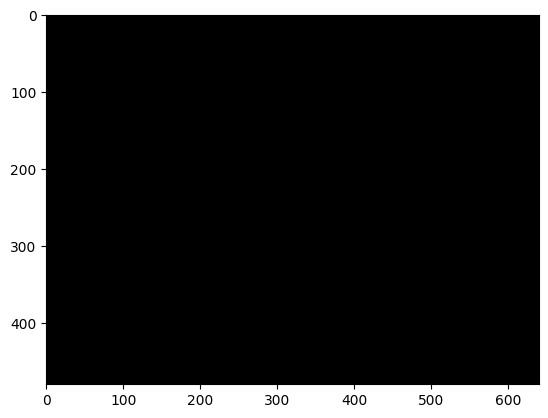

In [118]:
# Define a drawing function that will be called for each frame
def draw(i):
    plt.clf()  # Clear the current plot
    image = np.zeros((480, 640, 3), dtype=np.uint8)  # Create a blank image

    # Extract the landmarks for each type
    for landmark_type in ['face', 'pose', 'left_hand', 'right_hand']:
        # Ensure we sort the landmarks in ascending order to correctly draw the connections
        landmarks_coords = data_2[(data_2['frame'] == i) & (data_2['type'] == landmark_type)].sort_values('landmark_index')[['x', 'y', 'z']].values

        if np.isnan(landmarks_coords).any() or landmarks_coords.shape[0] == 0:
            continue

        # Create the NormalizedLandmarkList
        landmark_list = landmark_pb2.NormalizedLandmarkList()

        for x, y, z in landmarks_coords:
            landmark = landmark_list.landmark.add()
            landmark.x = x
            landmark.y = y
            landmark.z = z

        # Draw the landmarks
        if landmark_type == 'face':
            mp_drawing.draw_landmarks(image, landmark_list, mp_holistic.FACEMESH_TESSELATION, landmark_drawing_spec=None, connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
        elif landmark_type == 'pose':
            mp_drawing.draw_landmarks(image, landmark_list, mp_holistic.POSE_CONNECTIONS, landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        elif landmark_type == 'left_hand':
            mp_drawing.draw_landmarks(image, landmark_list, mp_hands.HAND_CONNECTIONS, mp_drawing_styles.get_default_hand_landmarks_style(), mp_drawing_styles.get_default_hand_connections_style())
        elif landmark_type == 'right_hand':
            mp_drawing.draw_landmarks(image, landmark_list, mp_hands.HAND_CONNECTIONS, mp_drawing_styles.get_default_hand_landmarks_style(), mp_drawing_styles.get_default_hand_connections_style())

    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)


# Create an animation by repeatedly calling draw() function
ani = animation.FuncAnimation(fig, draw, frames=len(valid_frames), interval=100)

# Convert the animation to HTML and display it
HTML(ani.to_jshtml())




In [13]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()
print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66


In [14]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size
print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


### Process Data Flow 

In [15]:
ROWS_PER_FRAME = 543  

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [16]:
data_2.shape


(4344, 7)

In [17]:
data_2.columns 

Index(['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z'], dtype='object')

In [19]:
data_2.describe()

,frame,landmark_index,x,y,z
count,4344.000000,4344.000000,4176.000000,4176.000000,4176.000000
mean,15.500000,202.994475,0.565157,0.436837,-0.056135
std,2.291552,146.807117,0.118846,0.228741,0.341006
min,12.000000,0.000000,-0.086693,0.140915,-3.471678
25%,13.750000,60.000000,0.518027,0.352897,-0.032548
50%,15.500000,196.000000,0.581521,0.410229,-0.008152
75%,17.250000,332.000000,0.636164,0.461996,0.012351
max,19.000000,467.000000,0.989077,2.238603,1.623417


In [37]:
for _, row in data_2.iterrows(): 
    if row['type'] == 'right_hand': 
        idx = RIGHT_HAND_IDXS0[row['landmark_index']]
    elif row['type'] == 'left_hand':
        idx = LEFT_HAND_IDXS0[row['landmark_index']]
    else:
        continue  # Skip this row if type is not right_hand or left_hand
    data[idx] = [row['x'], row['y'], row['z']]

In [21]:
data_2.tail()

,frame,row_id,type,landmark_index,x,y,z
4339,19,19-right_hand-16,right_hand,16,0.229135,0.158524,-0.118407
4340,19,19-right_hand-17,right_hand,17,0.137646,0.354542,-0.070975
4341,19,19-right_hand-18,right_hand,18,0.142946,0.291110,-0.099266
4342,19,19-right_hand-19,right_hand,19,0.157974,0.248765,-0.112596
4343,19,19-right_hand-20,right_hand,20,0.179431,0.212644,-0.121089


In [22]:
data_2

,frame,row_id,type,landmark_index,x,y,z
0,12,12-face-0,face,0,0.592258,0.443662,-0.036086
1,12,12-face-1,face,1,0.588944,0.413303,-0.074681
2,12,12-face-2,face,2,0.587292,0.422296,-0.037463
3,12,12-face-3,face,3,0.571926,0.375798,-0.060201
4,12,12-face-4,face,4,0.588335,0.402126,-0.080420
...,...,...,...,...,...,...,...
4339,19,19-right_hand-16,right_hand,16,0.229135,0.158524,-0.118407
4340,19,19-right_hand-17,right_hand,17,0.137646,0.354542,-0.070975
4341,19,19-right_hand-18,right_hand,18,0.142946,0.291110,-0.099266
4342,19,19-right_hand-19,right_hand,19,0.157974,0.248765,-0.112596
